In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Task:

1. Create a function that will automatically load information from the additional file *groups_add.csv* and recalculate metrics based on additional parameters.

2. Create a function that will display plots based on the metrics you got.

In [2]:
# Uploading data

groups = pd.read_csv('data/groups.csv', sep=';')
active_studs = pd.read_csv('data/active_studs.csv')
checks = pd.read_csv('data/checks.csv', sep=';')

#### Creating a function wich returns joined DataFrame and calculated metrics

In [3]:
def get_metrics(groups, active, checks):
    
    ''' This function returns joined DataFrame and main metrics.
    
        Parameters
        -------------
        groups: Pandas DataFrame
            DataFrame with data about users group
            (2 columns - 'id' and 'grp')
            
        active: Pandas DataFrame
            DataFrame with active users data
            (1 column - 'student_id')
            
        checks: Pandas DataFrame
            DataFrame with purchase data
            (2 columns - 'student_id' and 'rev')
            
        Returns
        -------------
        users: Pandas DataFrame
            
            Joined DataFrame with the following columns:Объединенный датафрейм со следующими колонками:
                
                student_id - students ID
                group - test group
                rev - purchase revenue
                has_payment - was payment or not (True/False)
                
        metrics: Pandas DataFrame
            
            Main metrics in each group:
            
                group - group name
                number_of_students - number of students in each group
                revenue - total revenue in each group
                purchases - number of purchases
                ARPU - average revenue per user
                AOV - average order value
                CR - conversion rate of an active student into a purchase
                
        '''
    
    # Rename columns to a single names
    groups = groups.rename(columns={'id': 'student_id', 'grp': 'group'})
    
    # Put into variable 'users' DataFrame with active users groups
    users = groups.merge(active_studs, on='student_id', how='inner')
    
    # Add purchase data to the 'users' DataFrame
    users = users.merge(checks, on='student_id', how='left')
    
    # Add column 'has_payment' with boolean data was payment or not
    users['has_payment'] = users.rev.apply(lambda x: x > 0)
    
    # Group data
    metrics = users.groupby('group', as_index=False) \
        .agg({'student_id': 'count', 'rev': 'sum', 'has_payment': 'sum'}) \
        .rename(columns={'student_id': 'number_of_students', 'has_payment': 'purchases', 'rev': 'revenue'})
    
    # Calculate metrics
    metrics['ARPU'] = metrics.revenue / metrics.number_of_students
    metrics['AOV'] = metrics.revenue / metrics.purchases
    metrics['CR'] = metrics.purchases / metrics.number_of_students
    
    return users, metrics

In [4]:
df, metrics = get_metrics(groups, active_studs, checks)

metrics

,group,number_of_students,revenue,purchases,ARPU,AOV,CR
0,A,1535,72820.0000,78,47.439739,933.589744,0.050814
1,B,6793,393074.0035,313,57.864567,1255.827487,0.046077


In [5]:
# Uploading additional data

groups_add = pd.read_csv('data/group_add.csv')

#### Let's create a decorator wich wrap the *get_metrics* function and joins groups data befor it runs

In [6]:
def add_groups(func):
    
    
    def wrapper(groups_1, groups_2, active, checks):
        
        # Join groups data
        groups_new = pd.concat([groups_1, groups_2]).reset_index(drop=True)
        
        return func(groups_new, active, checks)
        
    return wrapper

In [7]:
# Put into variable 'recalculate_metrics' 'get_metrics' function wrapped with decorator 'add_groups'

recalculate_metrics = add_groups(get_metrics)

In [8]:
# Recalculate metrics and final DataFrame

df, metrics = recalculate_metrics(groups_add, groups, active_studs, checks)

metrics

,group,number_of_students,revenue,purchases,ARPU,AOV,CR
0,A,1538,72820.0000,78,47.347204,933.589744,0.050715
1,B,6803,394974.0035,314,58.058798,1257.878992,0.046156


#### Let's create function wich drows plots of metrics we've calculated

In [9]:
def drow_plots(df, metrics, mean=False, median=False):
    '''
    This function drows 4 plots:
        
        Comparison of conversions in groups A and B  (plt.barplot)
        Comparison of ARPU in groups A and B         (plt.barplot)
        AOV distribution in group A                  (plt.hist)
        AOV distribution in group B                  (plt.hist)
        
    Parameters
    ------------
    df: Pandas DataFrame
        DataFrame with columns 'rev' and 'group'
        
    metrics: Pandas DataFrame
        Final DataFrame with calculated metrics.
        Required columns: 'group', 'CR', 'ARPU'
        
    mean: bool, optional
        If 'True' then there will be a vertical mean line on AOV distribution plots
    
    median: bool, optional
        If 'True' then there will be a vertical median line on AOV distribution plots
        
       
    '''
    
    # Set main parameters for seaborn
    sns.set(
        style='darkgrid',
        palette='viridis',
        rc={'figure.figsize': (18, 10)}
    )
    
    # Divide output on 4 plots    
    # Drow comparison of conversions in groups A and B
    plt.subplot(2, 2, 1)
    plt.title('Comparison of conversions in groups A and B', fontsize=16)
    sns.barplot(x='group', y='CR', data=metrics)
    plt.xlabel(None)
    plt.ylabel(None)
   
    # Drow comparison of ARPU in groups A and B
    plt.subplot(2, 2, 2)
    plt.title('Comparison of ARPU in groups A and B', fontsize=16)
    sns.barplot(x='group', y='ARPU', data=metrics)
    plt.xlabel(None)
    plt.ylabel(None)
    
    # Drow AOV distribution in group A  
    # The plot and title
    plt.subplot(2, 2, 3)
    plt.title('AOV distribution  in group A', fontsize=16)
    plt.hist(df[df.group == 'A'].rev, bins=16, color='#483c71')
    
    # If parameter mean=True - drow mean line and title
    if mean:
        plt.vlines(x=df[df.group == 'A'].rev.mean(), 
                   ymin=0, ymax=max(plt.yticks()[0]) * 0.95, 
                   linestyles='--', color='#116ab8')
        plt.text(x=df[df.group == 'A'].rev.mean() * 1.02,
                 y=max(plt.yticks()[0]) * 0.9,
                 s='Mean: ' + str(int(df[df.group == 'A'].rev.mean())), color='#116ab8')
    
    # If parameter median=True - drow median line and title
    if median:
        plt.vlines(x=df[df.group == 'A'].rev.median(), 
                   ymin=0, ymax=max(plt.yticks()[0]) * 0.95, 
                   linestyles='--', color='#b24434')
        plt.text(x=df[df.group == 'A'].rev.median() * 1.02,
                 y=max(plt.yticks()[0]) * 0.84,
                 s='Median: ' + str(int(df[df.group == 'A'].rev.median())), color='#b24434')
        
    # Drow AOV distribution in group B  
    # The plot and title
    plt.subplot(2, 2, 4)
    plt.title('AOV distribution in group B', fontsize=16)
    plt.hist(df[df.group == 'B'].rev, bins=16, color='#475c7f')
    
    # If parameter mean=True - drow mean line and title
    if mean:
        plt.vlines(x=df[df.group == 'B'].rev.mean(), 
                   ymin=0, ymax=max(plt.yticks()[0]) * 0.95, 
                   linestyles='--', color='#116ab8')
        plt.text(x=df[df.group == 'B'].rev.mean() * 1.02,
                 y=max(plt.yticks()[0]) * 0.9,
                 s='Mean: ' + str(int(df[df.group == 'B'].rev.mean())), color='#116ab8')
    
    # If parameter median=True - drow median line and title
    if median:
        plt.vlines(x=df[df.group == 'B'].rev.median(), 
                   ymin=0, ymax=max(plt.yticks()[0]) * 0.95, 
                   linestyles='--', color='#b24434')
        plt.text(x=df[df.group == 'B'].rev.median() * 1.02,
                 y=max(plt.yticks()[0]) * 0.84,
                 s='Median: ' + str(int(df[df.group == 'B'].rev.median())), color='#b24434')

    sns.despine()
    
    plt.show()

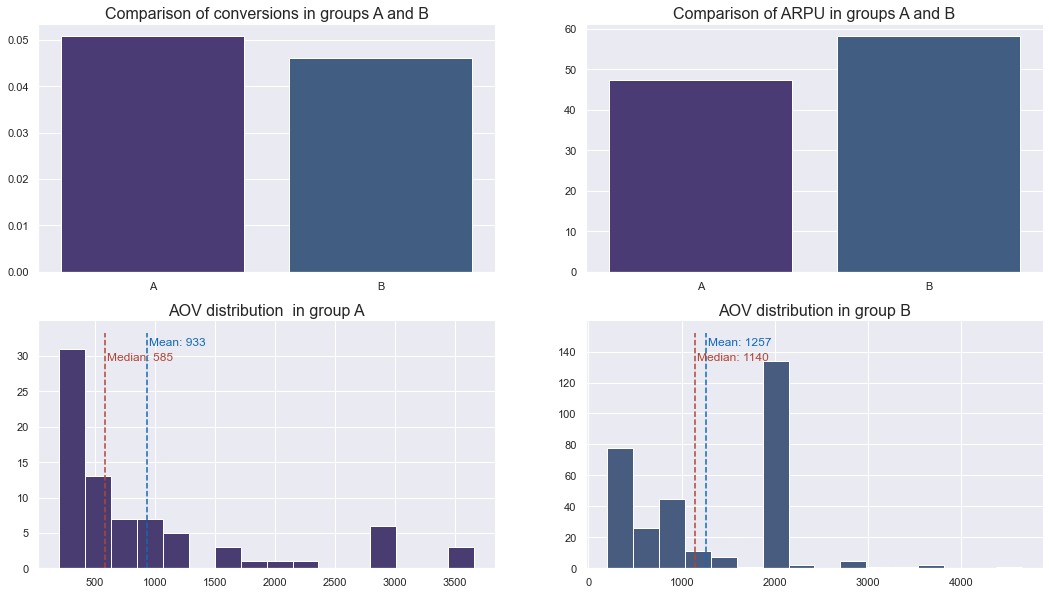

In [10]:
drow_plots(df, metrics, mean=True, median=True)